# Purpose

The purpose of this notebook is to create figures on adoption targeting. The ones we are going for are:

1. Plotting of flows for priority routes TO/FROM the metro. 

The idea we'll pursue is this: for most routes, changing to the metro would reduce overall congestion on the street layer. However, there are some routes for which changing to the metro could have a potentially large NEGATIVE impact on overall congestion. If we'd like these folks to use the metro, then we should put buses there. 

In [22]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting

from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import igraph
import pandas as pd
import matplotlib.cm as cm
import copy
from copy import deepcopy
import seaborn as sns

In [23]:
warnings.filterwarnings('ignore') # stops ipython from printing warnings


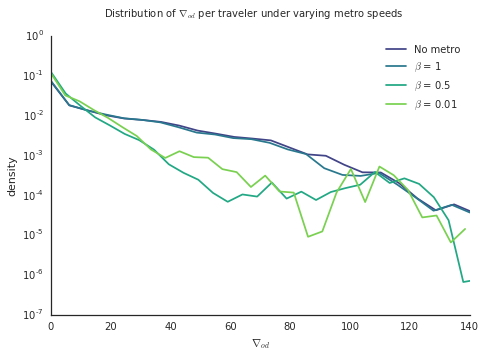

In [24]:
betas = [100, 1, 0.5, 0.01]
sns.set_style("white")
sns.set_palette(sns.color_palette("viridis", len(betas)))
current_palette = sns.color_palette()
fig = plt.figure(figsize = (7.5, 5))
ax1 = fig.add_subplot(111)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    dg = df[df.gamma > 0]
    if beta == 100:
        lab = 'No metro'
    else:
        lab = r'$\beta$ = ' + str(beta)
    viz.weighted_hist(ax = ax1, 
                      measure = dg.gradient, 
                      weights = dg.flow, 
                      label = lab,  
                      standardized = False,
                      color = current_palette[i],
                      n = 30)
    i += 1

ax1.set_yscale('log')
ax1.set(xlabel = r'$\nabla_{od}$', ylabel = 'density', xlim = (0, 140))
ax1.legend()
fig.suptitle(r'Distribution of $\nabla_{od}$ per traveler under varying metro speeds')

sns.despine()

plt.savefig('4_figs/gradient_dist.png')

In [25]:
pylab.rcParams['savefig.facecolor'] = 'black'

In [26]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

In [27]:
dists = nx.get_edge_attributes(multi.G, 'dist_km')
times = nx.get_edge_attributes(multi.G, 'free_flow_time_m')

speed_km_m = {key : dists[key]/times[key] for key in dists}

nx.set_edge_attributes(multi.G, 'speed_km_m', speed_km_m)

street_speed = multi.mean_edge_attr_per(layers = ['streets'], 
                                    attr = 'speed_km_m', 
                                    weight_attr = 'dist_km')

metro_speed = multi.mean_edge_attr_per(layers = ['metro'], 
                                   attr = 'speed_km_m', 
                                   weight_attr = 'dist_km') 

scale = street_speed / metro_speed

multi.scale_edge_attribute(layer = 'metro', 
                       attribute = 'free_flow_time_m', 
                       beta = 1/scale)

In [28]:
def wavg_constructor(col, weight):
    def wavg(group):
        d = group[col]
        w = group[weight]
        return (d * w).sum() / w.sum()
    return wavg

In [29]:
con_map = {int(multi.G.node[n]['con_name']) : n for n in multi.G.node if multi.G.node[n]['layer'] == 'taz'}

center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

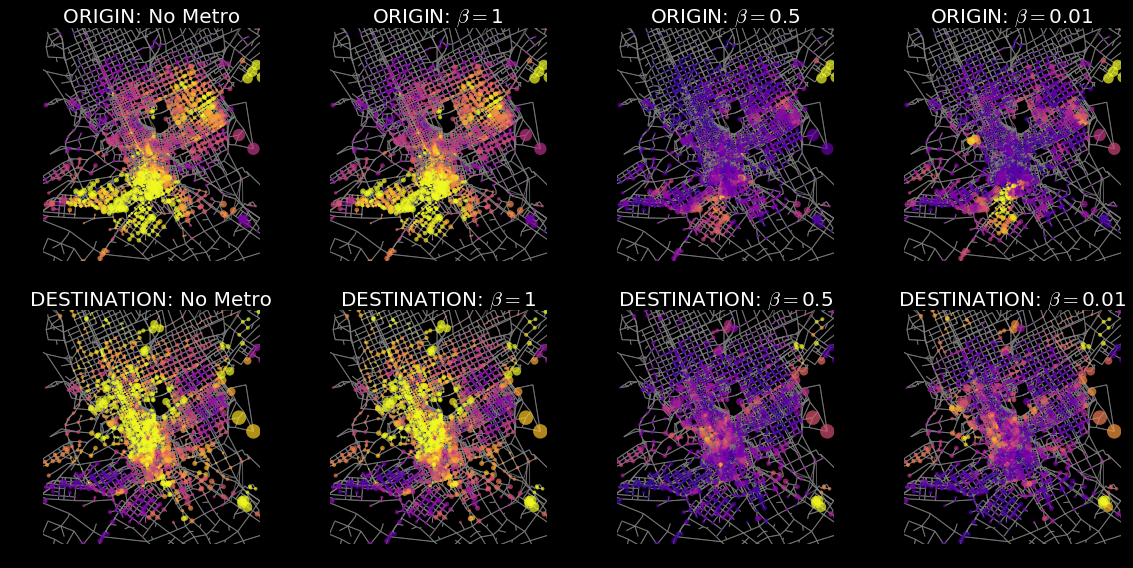

In [30]:
betas = [100, 1, 0.5, 0.01]

fig = plt.figure(figsize = (4 * len(betas),8))

i = 0

for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    wavg = wavg_constructor('gradient', 'flow')

    df['o_node'] = df.o_con.apply(con_map.get)
    df['d_node'] = df.d_con.apply(con_map.get)
    o_gradient   = df.groupby('o_node').apply(wavg).to_dict()
    o_flow       = df.groupby('o_node').flow.sum().to_dict()
    d_gradient   = df.groupby('d_node').apply(wavg).to_dict()
    d_flow       = df.groupby('d_node').flow.sum().to_dict()

    attrs = {'o_gradient' : o_gradient, 
             'o_flow'     : o_flow, 
             'd_gradient' : d_gradient, 
             'd_flow'     : d_flow}

    for attr in attrs:
        nx.set_node_attributes(multi.G, attr, 0)
        nx.set_node_attributes(multi.G, attr, attrs[attr])
    
    if beta == 100:
        beta_title = 'No Metro'
    else:
        beta_title = r'$\beta = $' + str(beta)
    
    ax1 = fig.add_subplot(2,len(betas),i + 1)
    plt.title('ORIGIN: ' + beta_title, 
              color = 'w', 
              fontsize = 20)

    ax2 = fig.add_subplot(2,len(betas), i + 1 + len(betas))
    plt.title(r'DESTINATION: ' + beta_title, 
              color = 'w', 
              fontsize = 20)
    i += 1

    viz.bubble_plot(multi.G, 
                    size = 'o_flow', 
                    color = 'o_gradient', 
                    size_factor = 0.05, 
                    ax = ax1, 
                    vmax = 25,
                    alpha = .7,
                    cmap = 'plasma',
                    linewidths = 0)

    
    viz.bubble_plot(multi.G, 
                    size = 'd_flow', 
                    color = 'd_gradient', 
                    size_factor = 0.05, 
                    ax = ax2, 
                    vmax = 25,
                    alpha = .7,
                    cmap = 'plasma',
                    linewidths = 0)
   
    
    ax1.set(xlim = xlim, ylim = ylim)
    
    ax2.set(xlim = xlim, ylim = ylim)

fig.set_facecolor("#000000")
plt.tight_layout()
plt.savefig('4_figs/gradient_spatial.png')

# Simulating targeting scenarios

In [31]:
multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [32]:
def od_total(od):
    return np.sum(np.sum(od[o].values()) for o in od)

def simulate(beta, n):
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    df['congestion_impact'] = df['gradient'] * df['flow']
    df = df.sort_values('congestion_impact', ascending = False)

    sub = df.head(n)
    ratio = 1 - sub.flow.sum() / df.flow.sum() # % of flow we are targeting here

    od = deepcopy(multi.od)
    
    # Targeted removal 
    for o, d in zip(sub.o_con, sub.d_con):
        multi.od[con_map[o]][con_map[d]] = 0
    
   

    multi.run_ita(n_nodes = None, 
                    summary = False, # change this to get route tables 
                    attrname = 'congested_time_m_TEST',
                    flow_name = 'flow_TEST',
                    P = [.2, .2, .2, .2, .1, .1],
                    scale = .25)
    
    targeted = multi.edges_2_df(['streets'], ['congested_time_m_TEST', 'flow_TEST', 'free_flow_time_m'])
    
    # Reset the OD
    multi.od = od
    
    # uniform removal
    for o in multi.od:
        for d in multi.od[o]:
            multi.od[o][d] *= ratio
    
    multi.run_ita(n_nodes = None, 
                    summary = False, # change this to get route tables 
                    attrname = 'congested_time_m_RAND',
                    flow_name = 'flow_RAND',
                    P = [.2, .2, .2, .2, .1, .1],
                    scale = .25)
    
    uniform = multi.edges_2_df(['streets', 'metro', 'metro--streets'], ['congested_time_m_RAND', 'flow_RAND', 'free_flow_time_m'])
    
    # Reset the OD again, so we can clean up. 
    multi.od = od
    
    return targeted, uniform

In [33]:
for beta in betas:
    multi.scale_edge_attribute(layer = 'metro',
                                 attribute = 'free_flow_time_m',
                                 beta = beta)
    
    targeted, uniform = simulate(beta = beta, n = 50000)
    
    multi.scale_edge_attribute(layer = 'metro',
                                 attribute = 'free_flow_time_m',
                                 beta = 1.0/beta)
    
    print str(beta)
    
    total = np.sum(targeted.congested_time_m_TEST * targeted.flow_TEST)
    congested = total - np.sum(targeted.free_flow_time_m * targeted.flow_TEST)
    print 'targeted: ' + str(total / od_total(multi.od) * 4) + ', ' +  str(congested / od_total(multi.od) * 4)
    
    total = np.sum(uniform.congested_time_m_RAND * uniform.flow_RAND)
    congested = total - np.sum(uniform.free_flow_time_m * uniform.flow_RAND)
    print 'uniform : ' + str(total / od_total(multi.od) * 4) + ', ' +  str(congested / od_total(multi.od) * 4)

assignment for p = 0.2 completed in 4.1m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.6m
assignment for p = 0.2 completed in 3.6m
assignment for p = 0.1 completed in 3.6m
assignment for p = 0.1 completed in 3.6m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.1 completed in 3.5m
assignment for p = 0.1 completed in 3.5m
100
targeted: 16.3868698768, 1.93260230525
uniform : 18.1563081174, 2.85817335845
assignment for p = 0.2 completed in 3.7m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.7m
assignment for p = 0.2 completed in 3.6m
assignment for p = 0.1 completed in 3.6m
assignment for p = 0.1 completed in 3.6m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.4m
assignment for p = 0.2 completed in 3.5m
assignment for p = 0.2 completed in 3.5m
assignment for p

In [ ]:
g, od = multi.to_igraph()

In [ ]:
pylab.rcParams['savefig.facecolor'] = 'black'
center_point = (46.7167, 24.6833)
l = .27

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

def gradient_route_plot(multi, beta, n, ax, size_factor = 1, vmax = 1000):
    from collections import defaultdict
    from copy import deepcopy
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    df['congestion_impact'] = df['gradient'] * df['flow']
    df = df.sort_values('congestion_impact', ascending = False)

    nx_keys = {v.index : v['name'] for v in g.vs}

    weight = 'congested_time_m_'+ str(beta)
    flow_dict = defaultdict(int)

    for o,d,flow in zip(df[:n].o_con, df[:n].d_con, df[:n].flow):
        path = g.get_shortest_paths(o,
                                    to = d,
                                    weights = weight,
                                    mode = 'OUT',
                                    output = 'epath')

        for e in path[0]:
            if len(path[0]) > 1:

                flow_dict[e] += flow

    flow_dict = {(g.es[e].source, g.es[e].target) : flow_dict[e] for e in flow_dict}
    flow_dict = {(nx_keys[e[0]], nx_keys[e[1]]) : flow_dict[e] for e in flow_dict}

    nx.set_edge_attributes(multi.G, 'fig_flow', 0)
    nx.set_edge_attributes(multi.G, 'fig_flow', flow_dict)

    H = copy.deepcopy(multi.G)
    for e in copy.deepcopy(H).edges_iter():
        if H.edge[e[0]][e[1]]['fig_flow'] < 0:
            H.remove_edge(e[0],e[1])
        if (H.edge[e[0]][e[1]]['layer'] == 'metro') | (H.edge[e[0]][e[1]]['layer'] == 'metro'):
            H.remove_edge(e[0],e[1])

    pylab.rcParams['savefig.dpi'] = 72
    cmap = 'viridis'

    G = multi.G


#     G.position = {n : (G.node[n]['lon'], G.node[n]['lat']) for n in G}

#     nx.draw(G, G.position,
#            edge_color = 'white',
#            arrows = False,
#            edge_size = 10,
#            ax = ax,
#            node_size = 0,
#            alpha = .15)

    H.position = {n : (H.node[n]['lon'], H.node[n]['lat']) for n in H}
    H.colors = [H.edge[e[0]][e[1]]['fig_flow'] for e in H.edges_iter()]
    H.widths = [H.edge[e[0]][e[1]]['fig_flow'] * size_factor for e in H.edges_iter()]
    nx.draw_networkx_edges(H, H.position, 
#                edge_color=H.colors, 
               arrows = False,
               edge_size = 100,
#                edge_cmap = plt.get_cmap(cmap),
               edge_color = 'white',
               ax = ax,
               width = H.widths,
               node_size = 0,
               edge_vmin = 0, 
               edge_vmax = vmax,
               alpha = 1)

    M = multi.layers_as_subgraph(['metro'])
    M.position = {n : (M.node[n]['lon'], M.node[n]['lat']) for n in M}

    nx.draw_networkx_edges(M, M.position,
            edge_color = 'grey', 
            width = 4,
            node_color = 'white',
            node_size = 0,
            alpha = .4,
            with_labels = False,
            arrows = False,
            ax = ax)

    

#     cols = plt.get_cmap(cmap)
#     m = cm.ScalarMappable(cmap=cols)
#     m.set_array([0, 6000])

#     cbar = fig.colorbar(m, 
#                  ax=ax, 
#                  aspect = 100, 
#                  format = ' ', 
#                  spacing = 'uniform')

#     cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')             
#     plt.setp(cbytick_obj, color='w')
#     plt.tight_layout()

fig = plt.figure(figsize = (20,5))
i = 0
for beta in [100, 1, 0.5, 0.01]:
# for beta in [100]:
    ax = fig.add_subplot(1,4,i+1)    
    gradient_route_plot(multi, beta = beta, ax = ax, n = 50000, size_factor = .001, vmax = 3000)
    ax.set(xlim = xlim, ylim = ylim)
    if beta == 100:
        title = 'No metro'
    else:
        title = r'$\beta =$ ' + str(beta)
    plt.title(title,
              color = 'w', 
              fontsize = 20)
    ax.set_axis_bgcolor('black')
    i += 1

fig.set_facecolor("#000000")
plt.savefig('4_figs/gradients.png')